In [3]:
#求理想环境和含噪环境的近似比
from mindquantum.core.circuit import Circuit, UN
from mindquantum.core.gates import H, Rzz, RX, RZ, RY,DepolarizingChannel
from mindquantum.core.operators import Hamiltonian, QubitOperator
from mindquantum.framework import MQAnsatzOnlyLayer
from mindquantum.simulator import Simulator
import mindspore.nn as nn
import mindspore as ms
ms.set_context(mode=ms.PYNATIVE_MODE, device_target="CPU")

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import networkx as nx
from IPython.display import Image

def build_ansatz(qubit, p, g,  problem):
    """
    qubit: 输入量子比特的数目
    p: 量子线路的层数
    g: max cut 的图
    J: 哈密顿量子项前的系数，如果是-1需要 Rz 门, 1,ZZ 门
    problem: 根据问题 "Max_cut" 或者 "SK_model" 产生不同的哈密顿量
    CD: True/False
    """
    circ = Circuit()
    # problem hamitonian
    if problem == "ideal_model":
        for i in range(p):
            #-------- problem hamitonian ------
            for index, z in enumerate(g.edges):
                circ += Rzz(f'g').on(z)
            #-------- mix hamitonian-----------
            for z in range(qubit):
                circ += RX(f'b').on(z)                  
                
    if problem == "noise_model":
        for i in range(p):
            #-------- problem hamitonian ------
            for index, z in enumerate(g.edges):
                circ += Rzz(f'g{i}').on(z)
                circ+=DepolarizingChannel(p1,2).on(z)
               
            #-------- mix hamitonian-----------
            for z in range(qubit):
                circ += RX(f'b').on(z)
                circ+=DepolarizingChannel(p1).on(z)
   
    return circ


/home/ma-user/anaconda3/envs/Mindquantum-0.9.0/lib/python3.9/site-packages/mindquantum/simulator/__init__.py:17: UserWarning: Disable mqvector gpu backend due to: Malloc GPU memory failed: cudaErrorInsufficientDriver, CUDA driver version is insufficient for CUDA runtime version
  from .available_simulator import SUPPORTED_SIMULATOR


In [4]:
# 搭建哈密顿量。
def build_ham(g):
    """
    g: max cut 的图
    """
    ham = QubitOperator()
    for index, i in enumerate(g.edges):
        ham += QubitOperator(f'Z{i[0]} Z{i[1]}')  # 生成哈密顿量Hc
    return ham

In [5]:
def get_expectation_of_hamitonian(circ, qubit, ham, pr):

    sim = Simulator('mqvector', qubit)
    sim.apply_circuit(circ, pr)
    result = sim.get_expectation(ham)
    # energy[k] = result.real
        
    return result.real
# 搭建哈密顿量。

def max_cut(ham_operator):
    
    # 首先根据哈密顿量的算符将其转化为矩阵形式。
    ham_matrix = ham_operator.matrix()
    ham_matrix = ham_matrix.todense()

    # calculate the eigenvalue and eigenvector
    eigval, eigvec = np.linalg.eig(ham_matrix)

    # ground energy
    min_cut_val = min(eigval).real
    
    return min_cut_val

In [15]:
#训练电路
def train(g, qubit, p, ham, problem):
    """
    g: max cut 的图
    qubit: 输入量子比特的数目
    p: 线路的层数
    ham: 问题哈密顿量
    problem:  "ideal_model" 或者 "noise_model" 

    """
    
    # bulid the quantum circuit
    init_state_circ = UN(H, qubit)                                  # 生成均匀叠加态，即对所有量子比特作用H门
    if problem == "ideal_model":
        ansatz = build_ansatz(qubit, p, g, problem)   # 生成 QAOA-ansat理想线路
    if problem == "noise_model":
        ansatz = build_ansatz(qubit, p, g,problem)   # 生成 noise-QAOA-ansatz线路

    
    circ = init_state_circ + ansatz                                # 将初始化线路与ansatz线路组合成一个线路
    # optimize the parameters
    sim = Simulator('mqvector', circ.n_qubits)   
    grad_ops = sim.get_expectation_with_grad(ham, circ)            # 获取计算变分量子线路的期望值和梯度的算子
    net = MQAnsatzOnlyLayer(grad_ops)                             
    opti = nn.Adam(net.trainable_params(), learning_rate=0.1)     
    train_net = nn.TrainOneStepCell(net, opti)                    
    for i in range(300):
        train_net()                                            # 将神经网络训练一步并计算得到的结果（切割边数）。注意：每当'train_net()'运行一次，神经网络就训练了一步
    
    pr = dict(zip(ansatz.params_name, net.weight.asnumpy()))   # 获取线路参数
        
    return circ, pr

In [10]:
#最大割求解（全连接图）
qubits = [4,6,8,10,12]#共5例
instance =10#实例次数
Approxi_ratio= [0]*instance*len(qubits)
Approxi_ratio_n= [0]*instance*len(qubits)
k=0
p=1#线路层次
p1=0.5#噪声系数
for qubit in tqdm(qubits):
    # 取10中不同的 3-Regular MaxCut 图
    for i in range(instance):
        maxcut_graph=nx.random_regular_graph(n=qubit, d = qubit-1) #产生边为d的全连接图
        #J = [1]*len(maxcut_graph.edges())
        ham_operator=build_ham(maxcut_graph)
        max_cut_val=max_cut(ham_operator)
        ham=Hamiltonian(ham_operator)
        #---------------------------------------------------
        # 通过 QAOA 计算基态能量
        circ, pr = train(maxcut_graph, qubit, p, ham, "ideal_model")
        expectation = get_expectation_of_hamitonian(circ, qubit, ham, pr)
        # 计算 QAOA 得出能量和准确能量的比值
        Approxi_ratio[k] = expectation/max_cut_val
        
        #---------------------------------------------------
        # 通过 DC-QAOA 计算基态能量
        circ, pr = train(maxcut_graph, qubit, p,ham, "noise_model")
        expectation_2 = get_expectation_of_hamitonian(circ, qubit, ham, pr)        # 计算 QAOA 得出能量和准确能量的比值
        Approxi_ratio_n[k] = expectation_2/max_cut_val
        k += 1
        # print(ham_operator)


 20%|██        | 1/5 [00:24<01:39, 24.92s/it]


KeyboardInterrupt: 

In [ ]:
#量子边数、qubits对AR的影响
plt.figure(1, dpi=300)
for i in range(5):

    plt.scatter(range(15*i,15*i+10), Approxi_ratio[10*i:10*(i+1)] , color='royalblue', label="IQAOA")
    plt.scatter(range(15*i,15*i+10), Approxi_ratio_n[10*i:10*(i+1)], color='darkorange', label="NQAOA")
    plt.xticks([5, 20, 35, 50, 65], ['4','6','8','10','12'], fontsize=15)
    plt.yticks(fontsize=15)
    plt.ylabel('Approx. Ratio', fontsize=20)
    plt.xlabel('Number of qubits', fontsize=20)
    plt.title("MaxCut of 5 instances in different qubits", fontsize=15)
    if i == 0:
        plt.legend(fontsize=10)
plt.show()
save_path="data/approximate ratio comparison.eps"
plt.savefig(save_path,dpi=300,format="eps")

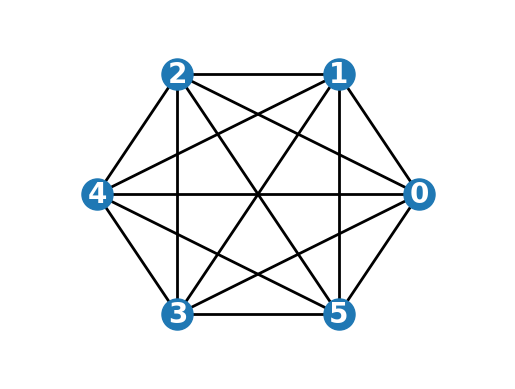

<Figure size 640x480 with 0 Axes>

In [20]:
#绘制k-正则图
n=6
k=n-1
V = [] # 顶点集合
for i in range(0,n):
    V.append(i)
# 正则度k(k需为偶数)，顶点数n
graph = nx.random_graphs.random_regular_graph(k,n)  #生成包含n个节点、每个节点有k个邻居的规则图RG

#print(graph.edges)
# 将生成的图 G 打印出来
pos = nx.circular_layout(graph)
options = {
    "with_labels": True,
    "font_size": 20,
    "font_weight": "bold",
    "font_color": "white",
    "node_size": 500,
    "width": 2
}
nx.draw_networkx(graph, pos, **options)
# graph
ax = plt.gca()
ax.margins(0.20)
plt.axis("off")
plt.show()
#my_logger.info('graph={}'.format(graph))
save_path="data/6 nodes Sk graph.eps"
plt.savefig(save_path,dpi=300,format="eps")

In [17]:
qubit = n
SK_instance = 10
layer = [1,2,3,4,5]
Approxi_ratio = np.zeros((SK_instance, len(layer)))
Approxi_ratio_n= np.zeros((SK_instance, len(layer)))
    
for i in tqdm(range(SK_instance)):

    #J = [np.random.choice([-1,1]) for _ in range(len(g.edges))]   # 随机生成 -1, 1
    ham_operator = build_ham(graph)                                # 根据图得到对应的哈密顿量算符
    ham = Hamiltonian(ham_operator)                               # 生成哈密顿量
    max_cut_val=max_cut(ham_operator)                              # 计算哈密顿量的基态能量
    
    for p in layer:
        
        #---------------------------------------------------
        # 通过 QAOA 计算基态能量
        circ, pr = train(graph, qubit, p, ham, "ideal_model")
        expectation = get_expectation_of_hamitonian(circ, qubit, ham, pr)
        Approxi_ratio[i,p-1] = expectation/max_cut_val

        #---------------------------------------------------
        # 通过 DC-QAOA 计算基态能量
        circ, pr = train(graph, qubit, p, ham, "noise_model",)
        expectation2 = get_expectation_of_hamitonian(circ, qubit, ham, pr)
        Approxi_ratio_n[i,p-1] = expectation2/max_cut_val

Approxi_ratio_mean = Approxi_ratio.mean(axis=0)
Approxi_ratio_n_mean = Approxi_ratio_n.mean(axis=0)

100%|██████████| 10/10 [03:34<00:00, 21.42s/it]


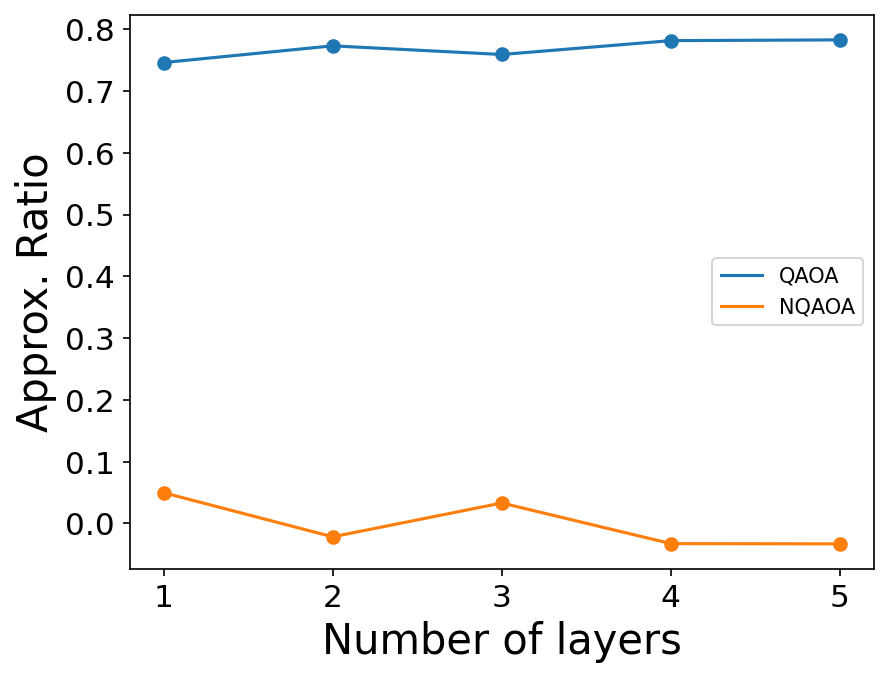

<Figure size 640x480 with 0 Axes>

In [19]:
plt.figure(1, dpi=150)
plt.plot(range(1,len(layer)+1),Approxi_ratio_mean, label="QAOA")
plt.scatter(range(1,len(layer)+1),Approxi_ratio_mean)
plt.plot(range(1,len(layer)+1),Approxi_ratio_n_mean, label="NQAOA")
plt.scatter(range(1,len(layer)+1),Approxi_ratio_n_mean)
#plt.ylim(0.2, 1)
plt.xticks([1,2,3,4,5],['1','2', '3','4','5'], fontsize=15)
plt.yticks(fontsize=15)
plt.ylabel('Approx. Ratio', fontsize=20)
plt.xlabel('Number of layers', fontsize=20)
plt.legend(fontsize=15)
plt.legend()
plt.show()
save_path="data/approximate ratio comparison with different layers(nodes=6).eps"
plt.savefig(save_path,dpi=300,format="eps")

In [ ]:
#输出柱状图
